# How to improve the delay

The kNN-VC conversion is very slow, leading to a delay larger than two seconds. This significantly hinders the interactiveness of the conversation. We will therefore investigate here what are the bottlenecks and how to improve them.

In [1]:
import os
import yaml

from matplotlib import pyplot as plt

In [9]:
def plot_delays(log_dir: str, param: str, max_y: float = None) -> None:
    delays = dict()
    for folder in os.listdir(log_dir):
        # get the processing size of the experiment
        config_file = os.path.join(log_dir, folder, "config.yaml")
        config = yaml.load(open(config_file, "r"), Loader=yaml.FullLoader)
        param_value = config["audio"][param]

        # get the audio delays
        log_file = os.path.join(log_dir, folder, "progress.log")
        delays[param_value] = dict()
        for line in open(log_file, "r"):
            if "audio output delay" in line:
                delay = float(line.split()[-2])
                time = line.split()[1].split(",")[0]
                if time not in delays[param_value]:
                    delays[param_value][time] = delay
                else:
                    delays[param_value][time] = max(delays[param_value][time], delay)

    # plot the delays
    plt.figure()
    for param_value, delay in delays.items():
        plt.plot(delay.values(), label=f"{param} {param_value}")
    if max_y is not None:
        plt.ylim(0, max_y)
    plt.xlabel("time (s)")
    plt.ylabel("delay (s)")
    plt.grid(which="both")
    plt.legend()
    plt.show()

## Processing Size

The audio processor receives a value called `processing_size`, which defines the number of samples that are passed to the VC model. As long as the minimum size expected by the model is respected, I believe there shouldn't be any quality deterioration from reducing it.

We run here the conversion model for several processing sizes and examine the results in terms of latency. The buffer size is always half of the processing size. The buffer size determines how many samples belong in a chunk that pyAudio passes to the processor.

There is a trade-off between the latency introduced by the chunking of the audio stream, and the latency introduced by the model's runtime. If the model requires more time to process a chunk, than the duration of the chunks it is given, the latency will continually increase.

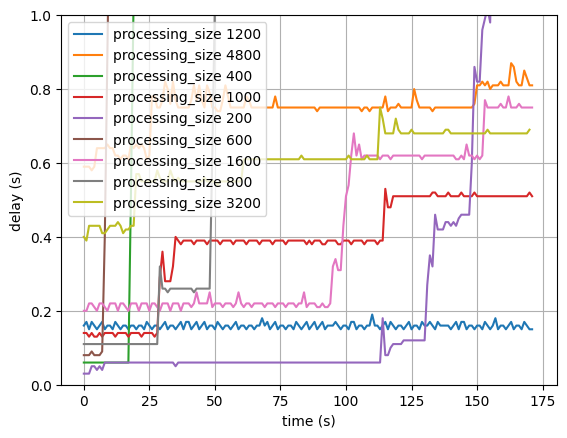

In [10]:
plot_delays("../logs/audio_proc_size/", "processing_size", max_y=1.)

* When the processing size is small (<1000), the latency explodes after less than a minute.
* Even for larger processing sizes (e.g. >1000), the latency can keep increasing over time.
* The model is never able to recover once it accumulates delay. This may be improved by VAD.

## Relationship between Proc. Size and Buffer Size

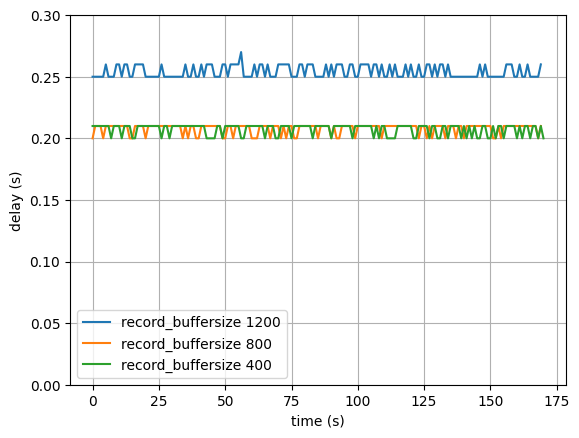

In [11]:
plot_delays("../logs/proc_vs_buffer/", "record_buffersize", max_y = 0.3)